In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# 0. Device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. EfficientNet-B4 모델 기본 구조 만들기
model = models.efficientnet_b4(pretrained=False)

# 2. classifier를 2개 클래스로 교체
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# 3. checkpoint 불러오기 및 로드
checkpoint = torch.load('/home/kangkr1002/facial_bone/efficientnet_b4_facial_bone.pth', map_location=device)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

# 4. device 이동 + eval 설정
model = model.to(device)
model.eval()
print("✅ 모델 로딩 완료")

/home/kangkr1002/micromamba/envs/capston-pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kangkr1002/micromamba/envs/capston-pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_1336820/373150852.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defa

✅ 모델 로딩 완료


In [3]:
transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.Lambda(lambda img: img.convert('RGB')),  # 1채널 → 3채널 복제
    transforms.ToTensor()
])


In [4]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients, self.activations = None, None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, x, target_class=None):
        out = self.model(x)
        if target_class is None:
            target_class = out.argmax(dim=1).item()
        self.model.zero_grad()
        target = out[:, target_class]
        target.backward()

        w = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (w * self.activations).sum(dim=1).squeeze()
        cam = torch.relu(cam)
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (x.size(2), x.size(3)))  # (W, H)로 리사이즈
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # 정규화
        return cam


In [7]:
def predict_and_visualize(img_path):
    img = Image.open(img_path)
    tensor = transform(img).unsqueeze(0).to(device)

    cam_gen = GradCAM(model, model.features[-1])
    cam = cam_gen.generate(tensor)

    output = model(tensor)
    probs = torch.softmax(output, dim=1)

    abnormal_prob = probs[0, 0].item()  # 🔥 Abnormal 확률은 0번 인덱스
    normal_prob = probs[0, 1].item()

    pred_class = 0 if abnormal_prob > 0.5 else 1  # 🔥 0이면 Abnormal, 1이면 Normal

    orig = np.array(img.resize((380, 380)))
    if orig.ndim == 2:
        orig = cv2.cvtColor(orig, cv2.COLOR_GRAY2RGB)

    heat = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(orig, 0.5, heat, 0.5, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    title = f'Pred: {"Abnormal" if pred_class == 0 else "Normal"} (Abnormal prob: {abnormal_prob:.3f})'
    plt.title(title)
    plt.axis('off')
    plt.show()


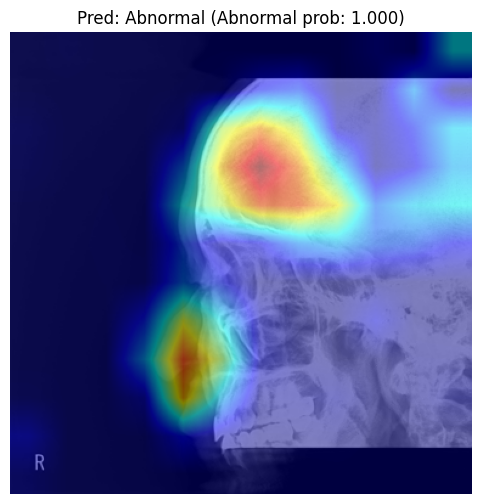

In [13]:
predict_and_visualize('/home/kangkr1002/facial_bone/Test/Abnormal/Facial_bone_Abnormal_00001055.png')
